## **1. Import the necessary libraries**
---

In [1]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import os, pathlib

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

model_folderpath = os.path.abspath(os.getcwd())
folderpath = pathlib.Path(model_folderpath).parent
data_folderpath = os.path.join(folderpath, 'Data')

print(folderpath)
print(model_folderpath)
print(data_folderpath)

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print(device_lib.list_local_devices())

C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel
C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model
C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Data
Versions of key libraries
---
tensorflow:  2.3.0
numpy:       1.18.5
matplotlib:  3.3.1
sklearn:     0.23.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11520222841279871613
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15172404935131843619
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7284610687568383960
physical_device_desc: "device: XLA_GPU device"
]


## **2. Create a function to plot image without axis**
---

In [2]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

<function implt at 0x00000222F14DCB80>


## **3. Set matplotlib to have seaborn plot style**
---

In [3]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **4. Prepare image data for training and testing**
---
URL: https://www.tensorflow.org/tutorials/load_data/images

* Step 1: Set model parameters
* Setp 2: Create a dataset (with/without generator for data augumentation)
* Step 2: Print the class names
* Step 3: Retrieve the row size and the column size of each image

Found 766 images belonging to 3 classes.
Found 189 images belonging to 3 classes.
Class labels are {'BeanSprout': 0, 'Potato': 1, 'Tomato': 2}
The shape of Training Data Batch is  (32, 256, 256, 3)
The shape of Training Label Batch is  (32, 3)
The shape of Testing Data Batch is  (32, 256, 256, 3)
The shape of Testing Label Batch is  (32, 3)


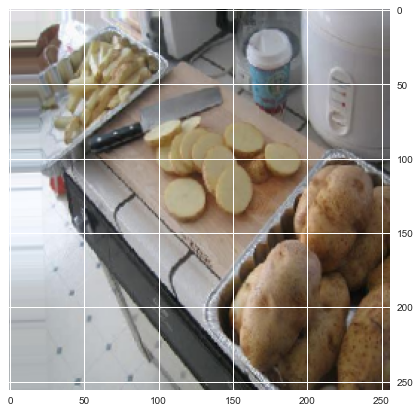

In [4]:
                                                                                # Step 1
batch_size = 32
img_height = 256
img_width = 256
seed = 42
validation_split = 0.2

                                                                                # Step 2
#Dataset with Generator (Need to check that validation dataset has no duplicates with training dataset)
trDatagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=validation_split)

tsDatagen = ImageDataGenerator( 
    validation_split=validation_split)

trDatasetIter = trDatagen.flow_from_directory(
    data_folderpath,
    target_size=(img_height, img_width),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    subset='training')

tsDatasetIter = tsDatagen.flow_from_directory(
    data_folderpath,
    target_size=(img_height, img_width),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    subset='validation')

                                                                                # Step 3
class_names = trDatasetIter.class_indices
print(f"Class labels are {class_names}")

                                                                                # Step 4
image_batch, label_batch = trDatasetIter.next()
print(f"The shape of Training Data Batch is  {image_batch.shape}")
print(f"The shape of Training Label Batch is  {label_batch.shape}")
plt.imshow((image_batch[0]).astype(np.uint8))

    
image_batch, label_batch = tsDatasetIter.next()
print(f"The shape of Testing Data Batch is  {image_batch.shape}")
print(f"The shape of Testing Label Batch is  {label_batch.shape}")


## 5. Define the model
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Define the number of classes
* Step 4: Define the convolutional neural network model (to be completed)
* Step 5: Create models for training and testing
* Step 6: Display the summary of the model of interest 

In [5]:
                                                                                # Step 1
learning_rate = 0.001
optmz       = optimizers.RMSprop(lr=learning_rate)

                                                                                # Step 2
modelname   = 'Food_Classification_Gen'

                                                                                # Step 3
num_classes = 3

                                                                                # Step 4
def createModel():
    
    xin = Input(shape=(256,256,3))
    x = Rescaling(1./255) (xin)
    
    x = Conv2D(64,(3,3),activation=None, padding='same')(x)
    x = Activation('relu') (x)

    x = MaxPooling2D(pool_size=(2,2)) (x)

    x = Conv2D(32,(3,3),activation=None, padding='same')(x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    
    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Conv2D(32,(3,3),activation=None, padding='same')(x)    
    x = Activation('relu') (x)

    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Conv2D(64,(3,3),activation=None, padding='same')(x)
    x = BatchNormalization() (x)   
    x = Activation('relu') (x)
    
    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Conv2D(128,(3,3),activation=None, padding='same')(x)    
    x = BatchNormalization() (x)       
    x = Activation('relu') (x)

    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Flatten() (x)
    x = Dense(64, activation='relu') (x)
    x = Dropout(0.5) (x)
    x = Dense(num_classes, activation='softmax') (x)


    model = Model(inputs=xin,outputs=x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz, 
                  metrics=['categorical_accuracy'])

    return model

                                                                                # Step 4
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()                                                                 # Step 5

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)     

## **6. Create the checkpoints to be applied during training**
---
* Step 1: Create a checkpoint to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a checkpoint to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two checkpoint objects into a list

In [6]:
                                                                                # Step 1
modelpath        = model_folderpath + '/' + modelname + ".hdf5"
logpath         = model_folderpath + '/' + modelname +'.csv'
checkpoint      = ModelCheckpoint(modelpath, 
                                  monitor='val_categorical_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                                                                                # Step 2
csv_logger      = CSVLogger(logpath)

                                                                                # Step 3
def lrSchedule(epoch):
    lr = learning_rate
    
    if epoch >= 45:
        lr *= 0.005
    elif epoch >= 35:
        lr *= 0.01
    elif epoch >= 25:
        lr *= 0.1

    print(f"Learning rate: {lr}")
    return lr 

LRScheduler = LearningRateScheduler(lrSchedule) 

                                                                               # Step 4
callbacks_list  = [checkpoint, csv_logger, LRScheduler]

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", modelpath)
print("Path to log:  ", logpath)

Callbacks created:

Path to model: C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model/Food_Classification_Gen.hdf5
Path to log:   C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model/Food_Classification_Gen.csv


## **7. Train the deep learning model**
___
URL: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [7]:
model.fit(trDatasetIter,                        # Training dataset
          validation_data=tsDatasetIter,        # Validation data and label
          epochs=100,                            # The amount of epochs to be trained                  
          shuffle=True,                         # To shuffle the training data
          callbacks=callbacks_list)             # Callbacks to execute the checkpoints

Learning rate: 0.001
Epoch 1/100
24/24 [==============================] - 39s 2s/step - loss: 3.4303 - categorical_accuracy: 0.4504 - val_loss: 1.0703 - val_categorical_accuracy: 0.4286
Learning rate: 0.001
Epoch 2/100
24/24 [==============================] - 41s 2s/step - loss: 0.8402 - categorical_accuracy: 0.5679 - val_loss: 1.2049 - val_categorical_accuracy: 0.2910
Learning rate: 0.001
Epoch 3/100
24/24 [==============================] - 40s 2s/step - loss: 0.6988 - categorical_accuracy: 0.6554 - val_loss: 1.6268 - val_categorical_accuracy: 0.2963
Learning rate: 0.001
Epoch 4/100
24/24 [==============================] - 40s 2s/step - loss: 0.6824 - categorical_accuracy: 0.6736 - val_loss: 1.3723 - val_categorical_accuracy: 0.3386
Learning rate: 0.001
Epoch 5/100
24/24 [==============================] - 40s 2s/step - loss: 0.5739 - categorical_accuracy: 0.7219 - val_loss: 1.5262 - val_categorical_accuracy: 0.3175
Learning rate: 0.001
Epoch 6/100
24/24 [==============================

Learning rate: 1e-05
Epoch 45/100
24/24 [==============================] - 40s 2s/step - loss: 0.2253 - categorical_accuracy: 0.8969 - val_loss: 0.1639 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 46/100
24/24 [==============================] - 40s 2s/step - loss: 0.2775 - categorical_accuracy: 0.9125 - val_loss: 0.1634 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 47/100
24/24 [==============================] - 40s 2s/step - loss: 0.2503 - categorical_accuracy: 0.8916 - val_loss: 0.1646 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 48/100
24/24 [==============================] - 41s 2s/step - loss: 0.2657 - categorical_accuracy: 0.8916 - val_loss: 0.1649 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 49/100
24/24 [==============================] - 40s 2s/step - loss: 0.2454 - categorical_accuracy: 0.8969 - val_loss: 0.1663 - val_categorical_accuracy: 0.9418
Learning rate: 5e-06
Epoch 50/100
24/24 [========================

Learning rate: 5e-06
Epoch 89/100
24/24 [==============================] - 40s 2s/step - loss: 0.2535 - categorical_accuracy: 0.9021 - val_loss: 0.1679 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 90/100
24/24 [==============================] - 40s 2s/step - loss: 0.2271 - categorical_accuracy: 0.9086 - val_loss: 0.1681 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 91/100
24/24 [==============================] - 40s 2s/step - loss: 0.2591 - categorical_accuracy: 0.9047 - val_loss: 0.1662 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 92/100
24/24 [==============================] - 40s 2s/step - loss: 0.2498 - categorical_accuracy: 0.8956 - val_loss: 0.1666 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 93/100
24/24 [==============================] - 40s 2s/step - loss: 0.2391 - categorical_accuracy: 0.8956 - val_loss: 0.1651 - val_categorical_accuracy: 0.9471
Learning rate: 5e-06
Epoch 94/100
24/24 [========================

## **8. Validate the deep learning model**
---
* Step 1: Set a list of image and labels for the test dataset 
* Step 2: Load the trained weights and compile the model
* Step 3: Make prediction


(189, 256, 256, 3)
(189, 3)
189
189
{'BeanSprout': 0, 'Potato': 1, 'Tomato': 2}
[0. 1. 0.]
Prediction completes.


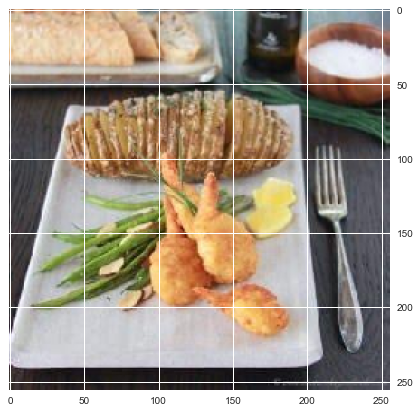

In [15]:
tsimages = []
tslabels = []
tsDatasetIter.reset()

for num_batches in range(tsDatasetIter.__len__()):
    image_batch, label_batch = tsDatasetIter.next()
    for i in range(len(label_batch)):
        tsimages.append(image_batch[i])
        tslabels.append(label_batch[i])

tsimages = np.array(tsimages)
        
print(np.shape(tsimages))
print(np.shape(tslabels))
print(len(tsimages))
print(len(tslabels))

plt.imshow(tsimages[0].astype(np.uint8))
print(class_names)
print(tslabels[0])

                                                                                # Step 2
modelGo.load_weights(modelpath)
modelGo.compile(loss='categorical_crossentropy',
                optimizer=optmz,
                metrics=['categorical_accuracy'])

                                                                                # Step 3
predicts    = modelGo.predict(tsimages)
print("Prediction completes.")

## **9. Report classification metrics**
---
* Step 1: Convert label from one-hot to integer
* Step 2: Obtain the class labels from the test dataset
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [9]:
                                                                                # Step 1
predout     = np.argmax(predicts,axis=1)

                                                                                # Step 2
testout     = np.argmax(tslabels, axis=1)

                                                                                # Step 3
testScores  = metrics.accuracy_score(testout, predout)                           

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 94.71%
              precision    recall  f1-score   support

  BeanSprout     0.9574    0.8824    0.9184        51
      Potato     0.9123    0.9455    0.9286        55
      Tomato     0.9647    0.9880    0.9762        83

    accuracy                         0.9471       189
   macro avg     0.9448    0.9386    0.9410       189
weighted avg     0.9475    0.9471    0.9467       189



## **10. Print confusion matrix**
---

In [10]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[45  4  2]
 [ 2 52  1]
 [ 0  1 82]]


## **11. Plot curves on validation loss and accuracy**
---

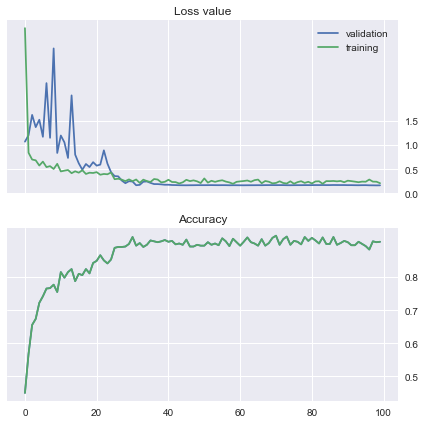

In [11]:
records     = pd.read_csv(logpath)
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['categorical_accuracy'],label="validation")
plt.plot(records['categorical_accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **12. Save the model plot**
---

In [12]:
plotpath  = model_folderpath + '/' + modelname + '_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Path to plot: C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model/Food_Classification_Gen_plot.png
